In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount("/content/my_drive")

Mounted at /content/my_drive


In [2]:

file1="/content/my_drive/MyDrive/Colab Notebooks/datasets/LankfordCoefficientPrediction/Matrix.h5"
file2="/content/my_drive/MyDrive/Colab Notebooks/datasets/LankfordCoefficientPrediction/LankfordDataset.h5"

In [3]:
import h5py

In [4]:
with h5py.File(file1,"r") as f:
  keys=list(f.keys())
  #print(keys)
  #print(len(keys))
  data_0=f[keys[0]]
  ODF_data=np.zeros((len(keys),data_0.shape[0]),dtype=np.int32)

  for i,key in enumerate(keys):

    ODF_data[i,:]=f[key][:]

    if (i+1)%1000==0:
      print(f'{i+1} files read')


1000 files read
2000 files read
3000 files read
4000 files read
5000 files read
6000 files read
7000 files read
8000 files read
9000 files read
10000 files read


In [5]:
ODF_data.shape

(10000, 361)

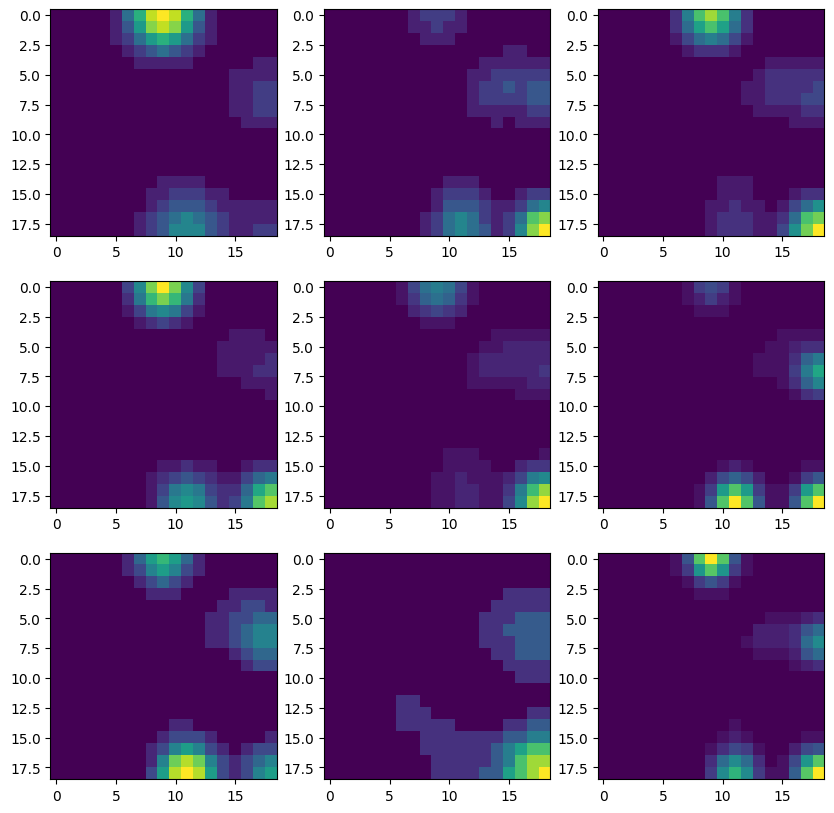

In [6]:
fig,axs=plt.subplots(3,3,figsize=(10,10))

for i,ax in enumerate(axs.flatten()):
  iodf=np.random.randint(0,ODF_data.shape[0]-1)
  odf=ODF_data[iodf,:].reshape(19,19)

  ax.imshow(odf.T)



In [7]:
with h5py.File(file2,'r') as f:
  print(f.keys())
  print(len(f.keys()))

  keys=f.keys()

  lankford_data=f["lankford_data"][:]

<KeysViewHDF5 ['lankford_data']>
1


In [8]:
lankford_data.shape

(10000, 7, 8)

In [9]:
# See the data of first file
# first column: inclination with respect to RD.
# second column: Anistropy of Young's modulus
# third column: r-value anistropy
L_data=lankford_data[0,:,:]
print(L_data)

[[  0.     195.6      0.68     0.8165  -0.3303  -0.4862 176.157   -7.485 ]
 [ 15.     168.       0.92     0.8165  -0.3914  -0.4251 168.663   -5.456 ]
 [ 30.     157.1      1.22     0.8165  -0.4495  -0.367  165.03    -0.526 ]
 [ 45.     166.4      0.93     0.8165  -0.3939  -0.4226 168.767    5.845 ]
 [ 60.     193.       0.66     0.8165  -0.3242  -0.4923 176.693    8.823 ]
 [ 75.     219.7      0.73     0.8165  -0.3436  -0.4729 184.355    4.978 ]
 [ 90.     220.8      1.16     0.8165  -0.4392  -0.3773 184.871   -5.889 ]]


In [10]:
r_values=lankford_data[:,:,2]

In [11]:
r_values.shape

(10000, 7)

In [12]:
r_values[0,:]

array([0.68, 0.92, 1.22, 0.93, 0.66, 0.73, 1.16], dtype=float32)

## r-values>3, we can consider outliers. As these values are not frequently observed. Sometime impractical. This is coming because of synthetic data generation.

# Data Preprocessing

In [13]:
# remove outliers from dataset
filter=np.any(r_values>3,axis=1)

r_values_sel=r_values[~filter]
odf_sel=ODF_data[~filter]

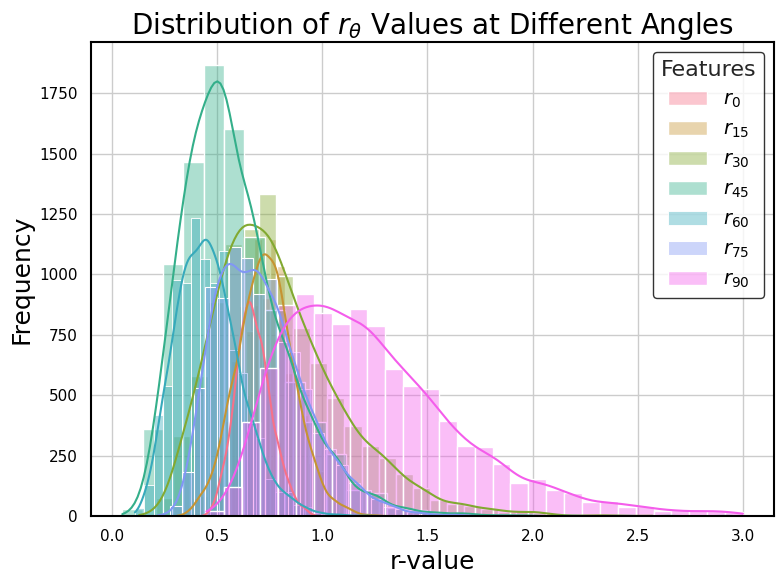

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

# Feature names with subscripts
feature_names = [r"$r_{0}$", r"$r_{15}$", r"$r_{30}$", r"$r_{45}$", r"$r_{60}$", r"$r_{75}$", r"$r_{90}$"]

# Color palette
palette = sns.color_palette("husl", n_colors=len(feature_names))

# Plot histograms
for i, name in enumerate(feature_names):
    sns.histplot(
        r_values_sel[:, i],
        bins=30,
        kde=True,
        color=palette[i],
        label=name,
        alpha=0.4
    )

# Titles and labels
plt.title("Distribution of $r_{θ}$ Values at Different Angles", fontsize=20, color='black')
plt.xlabel("r-value", fontsize=18, color='black')
plt.ylabel("Frequency", fontsize=18, color='black')

# Tick label colors
plt.xticks(color='black')
plt.yticks(color='black')

# Legend
plt.legend(title="Features", labelcolor='black', title_fontsize=16, fontsize=14, facecolor='white', edgecolor='black')

# Add black border to the plot area
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

# Add black border around the figure
#plt.gcf().patch.set_edgecolor('black')
#plt.gcf().patch.set_linewidth(2)

plt.tight_layout()
plt.show()


In [15]:
np.sum(filter)

np.int64(108)

In [16]:
print(r_values_sel.shape)
print(odf_sel.shape)

(9892, 7)
(9892, 361)


In [17]:
# normalize input
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
odf_sel=scaler.fit_transform(odf_sel)


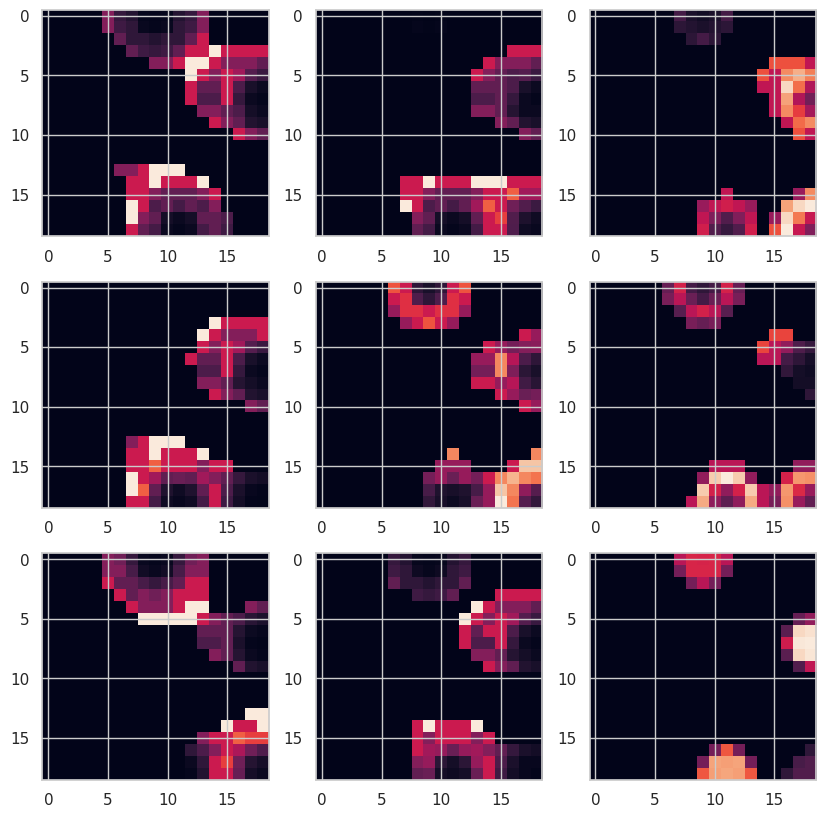

In [18]:
fig,axs=plt.subplots(3,3,figsize=(10,10))

for i,ax in enumerate(axs.flatten()):
  iodf=np.random.randint(0,odf_sel.shape[0]-1)
  odf=odf_sel[iodf,:].reshape(19,19)

  ax.imshow(odf.T)

In [19]:
# normalize outputs:
scaler_y=MinMaxScaler()
r_values_sel=scaler_y.fit_transform(r_values_sel)


r_min=scaler_y.data_min_
r_max=scaler_y.data_max_

print(r_min)
print(r_max)

[0.42 0.31 0.13 0.05 0.11 0.22 0.45]
[0.97 1.41 2.57 2.95 1.44 1.91 3.  ]


In [20]:
X=odf_sel
y=r_values_sel

In [21]:
X=X.reshape((X.shape[0],19,19,1))

In [22]:
X.shape

(9892, 19, 19, 1)

In [23]:
# construct a cnn to predict r-values
from tensorflow import keras
from keras.layers import Conv2D, Dense, Input, BatchNormalization, Activation, MaxPool2D, Flatten, Dropout,LeakyReLU
from keras.optimizers import Adam
from keras.models import Sequential

In [24]:
model=Sequential(
    [ Input(shape=(19,19,1)),

      Conv2D(filters=8,kernel_size=(3,3),padding="same"),
      BatchNormalization(), # regularizer
      Activation("relu"),
      MaxPool2D(pool_size=(2,2)),


      Conv2D(filters=16,kernel_size=(3,3),padding="same"),
      BatchNormalization(), # regularizer
      Activation("relu"),
      MaxPool2D(pool_size=(2,2)),

      Conv2D(filters=128,kernel_size=(3,3),padding="same"),
      BatchNormalization(), # regularizer
      Activation("relu"),
      MaxPool2D(pool_size=(2,2)),


      Flatten(),
      Dense(128,activation="relu"),
      #Dropout(0.2),
      Dense(64,activation="relu"),
      #Dropout(0.2),
      Dense(7,activation="linear") # output layer





    ])

# try adding more convolutional blocks
# try to increase number of filters
# try to change kernel_size

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 19, 19, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 19, 19, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 19, 19, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 9, 9, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 9, 9, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 9, 9, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 9, 9, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        18,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,791 (370.28 KB)

 Trainable params: 94,487 (369.09 KB)

 Non-trainable params: 304 (1.19 KB)

In [26]:
model.compile(optimizer=Adam(learning_rate=0.001),loss="mse",metrics=["mae"])

In [27]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [28]:
model.fit(X_train,y_train,epochs=100,batch_size=32,validation_split=0.1)

Epoch 1/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.1708 - mae: 0.1994 - val_loss: 0.0352 - val_mae: 0.1437
Epoch 2/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0067 - mae: 0.0623 - val_loss: 0.0087 - val_mae: 0.0698
Epoch 3/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0042 - mae: 0.0494 - val_loss: 0.0042 - val_mae: 0.0477
Epoch 4/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0037 - mae: 0.0463 - val_loss: 0.0025 - val_mae: 0.0367
Epoch 5/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0029 - mae: 0.0407 - val_loss: 0.0025 - val_mae: 0.0365
Epoch 6/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0023 - mae: 0.0359 - val_loss: 0.0022 - val_mae: 0.0357
Epoch 7/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0023 - mae: 0.0361 - val_loss: 0.0022 - val_mae: 0.0348
Epoch 8/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0021 - mae: 0.0349 - val_loss: 0.0021 - val_mae: 0.0351
Epoch 9/100
223/223 ━━━━━━━━━━━━━━━━━━━

In [29]:
# compute scores of training and testing
train_scores=model.evaluate(X_train,y_train)
test_scores=model.evaluate(X_test,y_test)
print(train_scores)
print(test_scores)

248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 6.1293e-04 - mae: 0.0184
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.1623e-04 - mae: 0.0219
[0.0006464967154897749, 0.018613409250974655]
[0.000917757919523865, 0.022002283483743668]


In [32]:
from sklearn.metrics import r2_score
r2_raw = r2_score(y_train, model.predict(X_train), multioutput='raw_values')
print(r2_raw)

248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
[0.94188327 0.95099944 0.9675726  0.9676083  0.9715904  0.9693312
 0.9728044 ]


In [33]:
# compute R2 score for training and testing
from sklearn.metrics import r2_score

y_pred=model.predict(X_test)
r2_train=r2_score(y_train,model.predict(X_train))
r2_test=r2_score(y_test,y_pred)
print(r2_train)
print(r2_test)

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
0.9631128311157227
0.9484990835189819


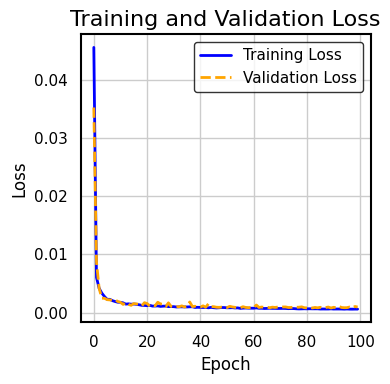

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


# Convert to a dictionary if needed
hist = model.history.history

plt.figure(figsize=(4, 4))

# Plot losses
plt.plot(hist['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(hist['val_loss'], label='Validation Loss', color='orange', linewidth=2, linestyle='--')

# Labels and title
plt.title('Training and Validation Loss', fontsize=16, color='black')
plt.xlabel('Epoch', fontsize=12, color='black')
plt.ylabel('Loss', fontsize=12, color='black')

# Customize ticks and legend
plt.xticks(color='black')
plt.yticks(color='black')
plt.legend(labelcolor='black', facecolor='white', edgecolor='black')

# Add black border to plot area
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

# Add outer border
#plt.gcf().patch.set_edgecolor('black')
#plt.gcf().patch.set_linewidth(2)

plt.tight_layout()
plt.show()


In [35]:
y_pred=model.predict(X_test)

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


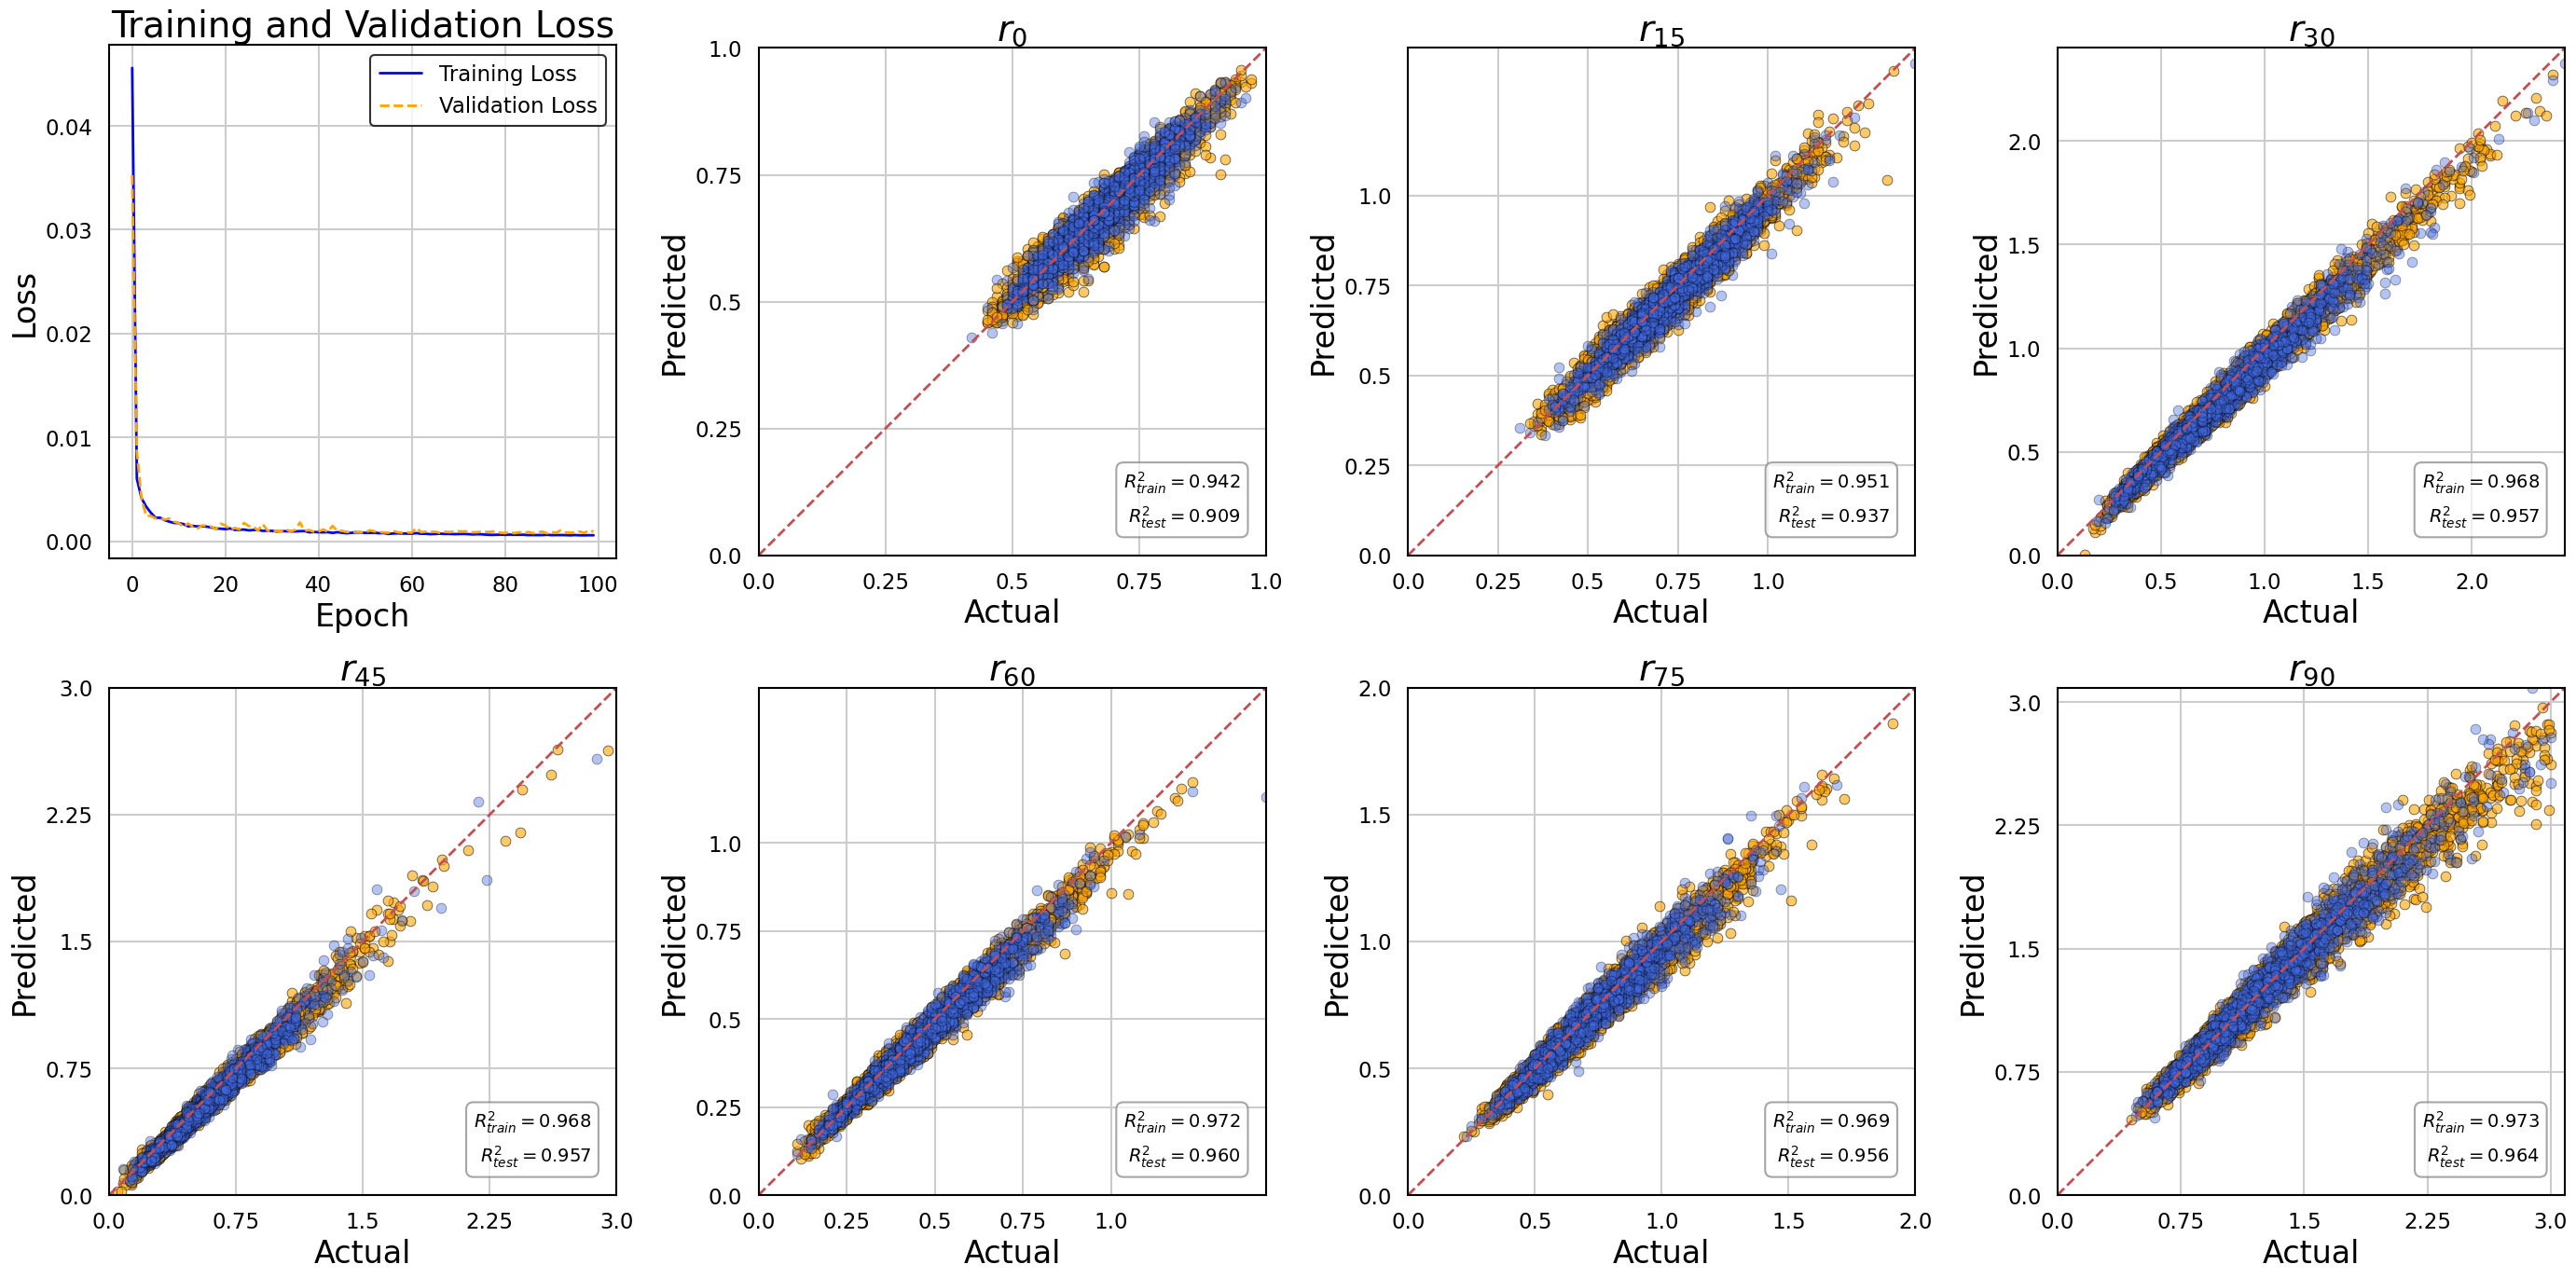

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score

sns.set(style="whitegrid", context="talk")

feature_names = [r"$r_{0}$", r"$r_{15}$", r"$r_{30}$", r"$r_{45}$", r"$r_{60}$", r"$r_{75}$", r"$r_{90}$"]
fig, axs = plt.subplots(2, 4, figsize=(28, 14))
ind = [0, 1, 2, 3, 4, 5, 6]

for i, ax in enumerate(axs.flatten()):
    if i == 0:
        # --- Training & Validation Loss ---
        ax.plot(hist['loss'], label='Training Loss', color='blue', linewidth=2)
        ax.plot(hist['val_loss'], label='Validation Loss', color='orange', linewidth=2, linestyle='--')

        ax.set_title('Training and Validation Loss', fontsize=28, color='black')
        ax.set_xlabel('Epoch', fontsize=24, color='black')
        ax.set_ylabel('Loss', fontsize=24, color='black')
        ax.tick_params(colors='black')
        ax.legend(labelcolor='black', facecolor='white', edgecolor='black')

        # Black border
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.5)

        continue

    if i > len(ind):  # hide extra subplot if exists
        ax.axis('off')
        continue

    # --- Actual vs Predicted ---
    actual_train = r_min[ind[i-1]] + y_train[:, ind[i-1]] * (r_max[ind[i-1]] - r_min[ind[i-1]])
    predicted_train = r_min[ind[i-1]] + model.predict(X_train)[:, ind[i-1]] * (r_max[ind[i-1]] - r_min[ind[i-1]])
    actual = r_min[ind[i-1]] + y_test[:, ind[i-1]] * (r_max[ind[i-1]] - r_min[ind[i-1]])
    predicted = r_min[ind[i-1]] + y_pred[:, ind[i-1]] * (r_max[ind[i-1]] - r_min[ind[i-1]])

    # R² calculation
    r2_train = r2_score(actual_train, predicted_train)
    r2_test= r2_score(actual, predicted)

    # Scatter plot
    sns.scatterplot(
        x=actual_train, y=predicted_train,
        s=60, alpha=0.6, color="orange",
        edgecolor="black", ax=ax
    )
    sns.scatterplot(
        x=actual, y=predicted,
        s=60, alpha=0.4, color="royalblue",
        edgecolor="black", ax=ax
    )


    # Equal scaling
    min_val = min(np.min(actual), np.min(predicted))
    max_val = max(np.max(actual), np.max(predicted))
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    ax.set_aspect('equal', adjustable='box')

    # 1:1 line
    ax.plot([0, np.ceil(max_val)], [0, np.ceil(max_val)], "r--", lw=2)

    # Labels and title
    ax.set_xlabel("Actual", fontsize=24, color='black')
    ax.set_ylabel("Predicted", fontsize=24, color='black')
    ax.set_title(feature_names[ind[i-1]], fontsize=28, color='black')
    ax.tick_params(colors='black')

    # Rounded ticks
    ticks = np.linspace(np.round(min_val), np.round(max_val), 5)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(ticks, color='black')
    ax.set_yticklabels(ticks, color='black')

    # Border
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)


    ax.text(
    0.95, 0.05,
    f"$R^2_{{train}} = {r2_train:.3f}$\n$R^2_{{test}} = {r2_test:.3f}$",
    transform=ax.transAxes,
    fontsize=14,
    color='black',
    ha='right',
    va='bottom',
    linespacing=1.5,
    bbox=dict(
        facecolor='white',   # white background
        edgecolor='gray',    # soft border
        boxstyle='round,pad=0.4',
        alpha=0.7            # slight transparency
        )
      )



# Hide the empty last subplot
#axs[1, 3].axis('off')

# Outer figure border
#fig.patch.set_edgecolor('black')
#fig.patch.set_linewidth(2)

plt.tight_layout()
plt.show()


In [ ]:
y_pred.shape

(1979, 7)

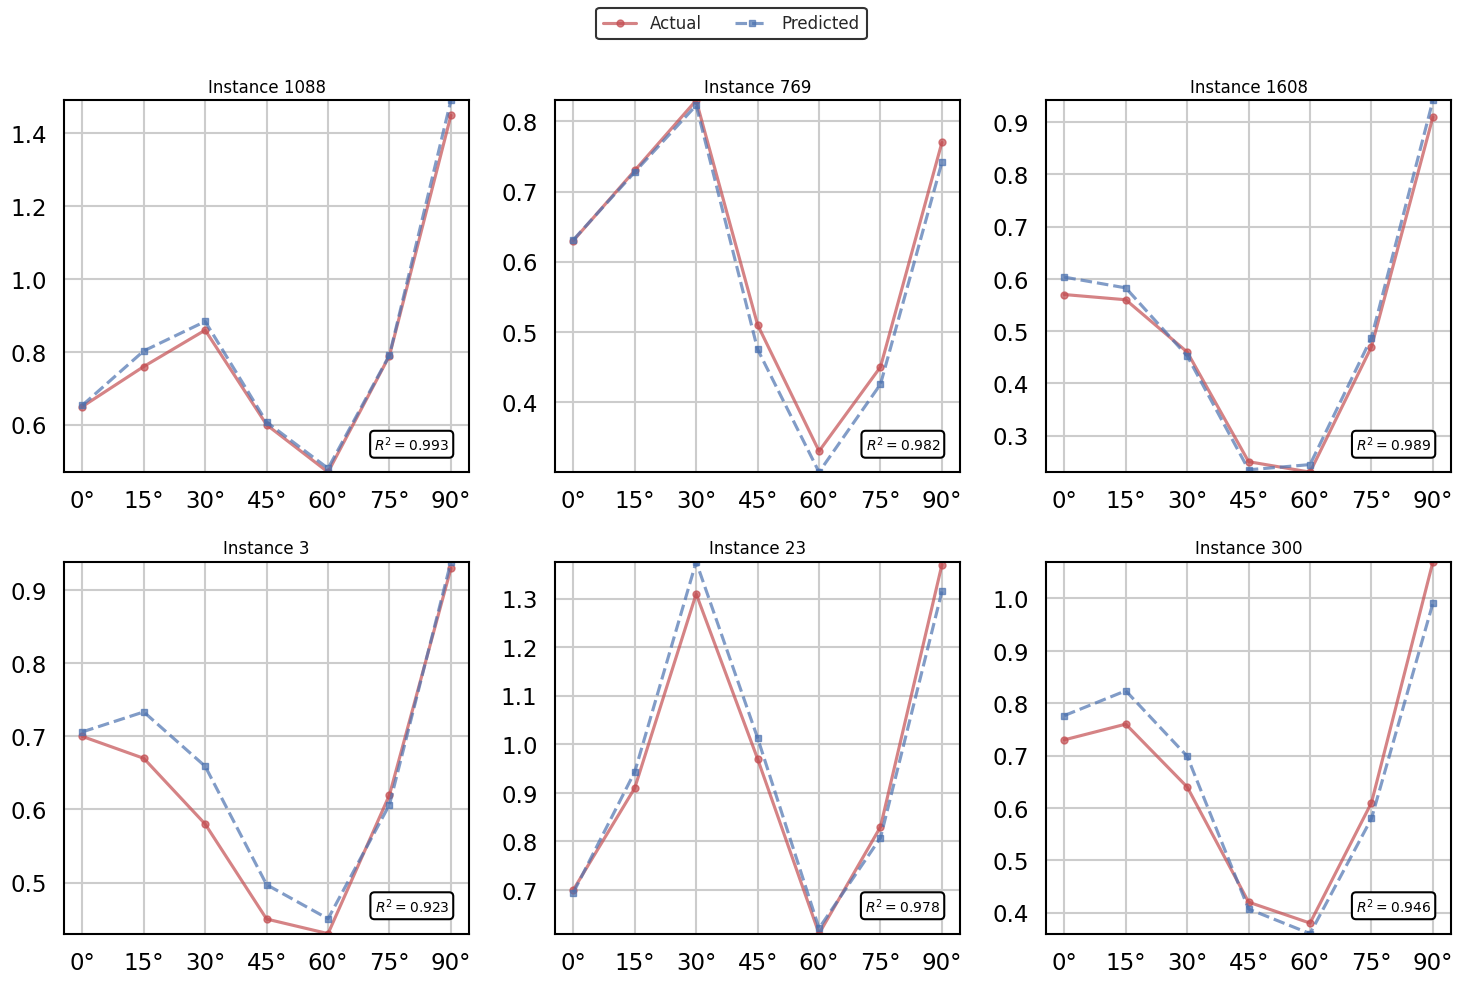

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score

sns.set(style="whitegrid", context="talk")

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# X-axis: angles 0° to 90° in steps of 15
angles = np.arange(0, 91, 15)

for i, ax in enumerate(axs.flatten()):
    # Random instance
    ith = np.random.randint(0, y_test.shape[0])

    # Scale actual and predicted
    actual = r_min + y_test[ith, :] * (r_max - r_min)
    predicted = r_min + y_pred[ith, :] * (r_max - r_min)

    # Compute R²
    r2 = r2_score(actual, predicted)

    # Plot lines with markers
    ax.plot(actual, 'ro-', label='Actual', markersize=5, alpha=0.7)
    ax.plot(predicted, 'bs--', label='Predicted', markersize=5, alpha=0.7)

    # Set X-axis labels as angles
    ax.set_xticks(np.arange(len(angles)))
    ax.set_xticklabels([f"{angle}°" for angle in angles], color='black')

    # Axis styling
    ax.set_ylim([np.min([actual.min(), predicted.min()]), np.max([actual.max(), predicted.max()])])
    ax.set_title(f'Instance {ith}', fontsize=12, color='black')
    ax.tick_params(axis='y', colors='black')

    # Display R²
    ax.text(
        0.95, 0.05, f"$R^2={r2:.3f}$",
        transform=ax.transAxes,
        fontsize=10,
        color='black',
        ha='right',
        va='bottom',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )

    # Black borders
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)

# Single legend for all subplots
fig.legend(['Actual', 'Predicted'], loc='upper center', ncol=2, fontsize=12,
           frameon=True, edgecolor='black', facecolor='white')

# Outer figure border
#fig.patch.set_edgecolor('black')
#fig.patch.set_linewidth(2)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for legend
plt.show()
